# HW2
# 12110820 胡嘉维

+ Read the data

In [61]:
import pandas as pd

df_offer = pd.read_csv("datasets/data_offers.csv")
df_order = pd.read_csv("datasets/data_orders.csv")

In [62]:
df_offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [63]:
df_order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


## 1. Distribution of Order Fails

+ The missing in `m_order_eta` are exactly those with `is_driver_assigned_key` = 0.

In [64]:
# Check for missing values
df_order["m_order_eta"].isna().sum(), \
    df_order["is_driver_assigned_key"].isna().sum()

(7902, 0)

In [65]:
df_order["is_driver_assigned_key"].astype(bool)

0         True
1        False
2         True
3         True
4        False
         ...  
10711    False
10712    False
10713     True
10714    False
10715     True
Name: is_driver_assigned_key, Length: 10716, dtype: bool

In [66]:
(df_order["is_driver_assigned_key"].astype(bool) == ~df_order["m_order_eta"].isna()).unique()

array([ True])

+ The missing in `cancellations_time_in_seconds` are exactly those with `order_status_key` = 9 (those rejected by the system). 

In [67]:
# Check for missing values
df_order["cancellations_time_in_seconds"].isna().sum(), \
    df_order["order_status_key"].isna().sum()

(3409, 0)

In [68]:
(df_order["cancellations_time_in_seconds"].isna() == (df_order["order_status_key"] == 9)).unique()

array([ True])

In [69]:
# Check for invalid values
(df_order["cancellations_time_in_seconds"]<0).unique()

array([False])

+ Hence the fail orders can be grouped by `order_status_key` and `is_driver_assigned_key`.
  + `is_driver_assigned_key` = 0, `order_status_key` = 4: no driver assigned, rejected by client;
  + `is_driver_assigned_key` = 0, `order_status_key` = 9: no driver assigned, rejected by system;
  + `is_driver_assigned_key` = 1, `order_status_key` = 4: some driver assigned, rejected by client;
  + `is_driver_assigned_key` = 1, `order_status_key` = 9: some driver assigned, rejected by system.

In [70]:
df_order.groupby(["is_driver_assigned_key", "order_status_key"]).size()

is_driver_assigned_key  order_status_key
0                       4                   4496
                        9                   3406
1                       4                   2811
                        9                      3
dtype: int64

+ Plot a bar chart to show the distribution of order fails over these four categories.

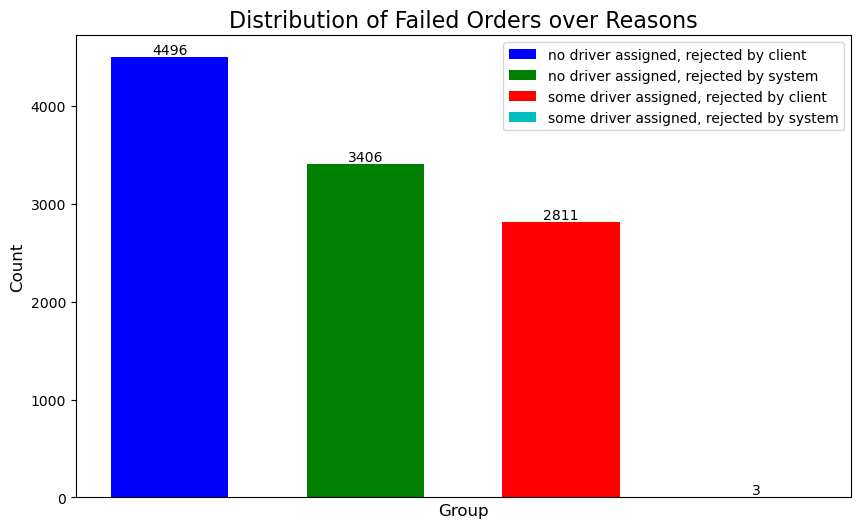

In [71]:
import matplotlib.pyplot as plt
import numpy as np

fail_reason = df_order.groupby(["is_driver_assigned_key", "order_status_key"]).size()

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

values = fail_reason.values
colors = ['b', 'g', 'r', 'c']
labels = ["no driver assigned, rejected by client", 
          "no driver assigned, rejected by system", 
          "some driver assigned, rejected by client",
          "some driver assigned, rejected by system"]

for i in range(len(values)):
    ax.bar(i, values[i], color=colors[i % len(colors)], label=labels[i], width=0.6)
    ax.text(i, values[i], str(values[i]), ha='center', va='bottom')

ax.set_xlabel('Group', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Failed Orders over Reasons', fontsize=16)
ax.set_xticks([])
ax.legend()

plt.show()

We see that the most common case for order fails is the ones rejected by the client before being accepted by the driver. There are also rare cases (only 3 appearances) that an order has been assigned to a driver but is rejected by the system later. And we have no evidence to judge such records as abnormal data.

In [72]:
df_order[(df_order["is_driver_assigned_key"] == 1) & (df_order["order_status_key"] == 9)]

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
1158,16:49:55,-0.974337,51.465422,418.0,3000631256425,9,1,NaN
6881,00:44:03,-0.973348,51.453919,60.0,3000630156338,9,1,NaN
7968,00:12:02,-0.974735,51.454823,298.0,3000600112433,9,1,NaN


## 2. Distribution of Order Fails by Hours

In [73]:
# Check for missing values
df_order["order_datetime"].isna().sum()

0

In [74]:
df_order["order_datetime"]
# type(df_order["order_datetime"][0])

0        18:08:07
1        20:57:32
2        12:07:50
3        13:50:20
4        21:24:45
           ...   
10711    13:11:35
10712    13:13:55
10713    13:17:21
10714    13:16:28
10715    11:49:35
Name: order_datetime, Length: 10716, dtype: object

In [75]:
df_order["hour"] = df_order["order_datetime"].apply(lambda time: time.split(":")[0])
df_order["hour"].unique()

array(['18', '20', '12', '13', '21', '07', '08', '06', '15', '16', '00',
       '14', '17', '22', '01', '19', '03', '23', '09', '02', '11', '04',
       '10', '05'], dtype=object)

In [76]:
fail_hour = df_order.groupby("hour").size()
fail_hour

hour
00     683
01     471
02     555
03     513
04     152
05      67
06     159
07     447
08    1082
09     412
10     170
11     193
12     256
13     366
14     256
15     439
16     356
17     541
18     414
19     317
20     469
21     846
22     716
23     836
dtype: int64

+ Which hours have the most order fails? Plot the hourly fail orders in one day and find the top 6.

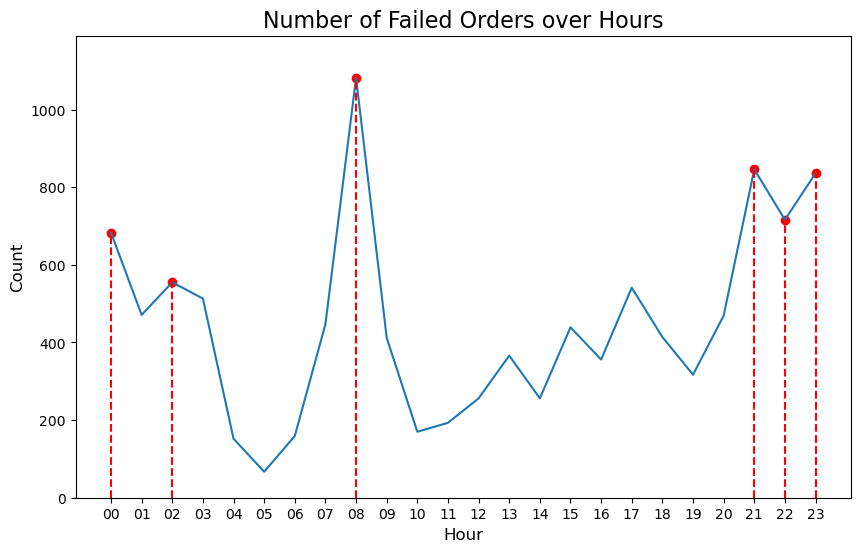

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(fail_hour)

tops = fail_hour.nlargest(6)
plt.scatter(tops.index, tops.values, color='r')

for x, y in zip(tops.index, tops.values):
    plt.vlines(x=x, ymin=0, ymax=y, color='r', linestyle='--')

plt.ylim(0, max(fail_hour) * 1.1)
plt.xlabel("Hour", fontsize=12)
plt.xticks(np.arange(0, 24, 1))
plt.ylabel("Count", fontsize=12)
plt.title("Number of Failed Orders over Hours", fontsize=16)
plt.show()

The hours with the most order fails are 8:00 ~ 9:00 and those in the late night, 21:00 ~ 2:00. It seems that 8:00 ~ 9:00 is the morning rush hour, 21:00 ~ 22:00 is the night rush hour, and afterward (22:00 ~ 2:00) the drivers go home for a rest.

+ Calculate the proportion of fail reasons by hours.

In [78]:
reasons = df_order.groupby(["is_driver_assigned_key", "order_status_key"])
df_order_nc, df_order_ns, df_order_sc, df_order_ss = \
    reasons.get_group((0,4)), reasons.get_group((0,9)), \
        reasons.get_group((1,4)), reasons.get_group((1,9))

+ Plot the hourly proportion of different fail reasons. For each fail reason, highlight the hours with top 6 proportions. Since only 3 records are of the type `is_driver_assigned_key` = 1, `order_status_key` = 9, we ignore this type in the plot.

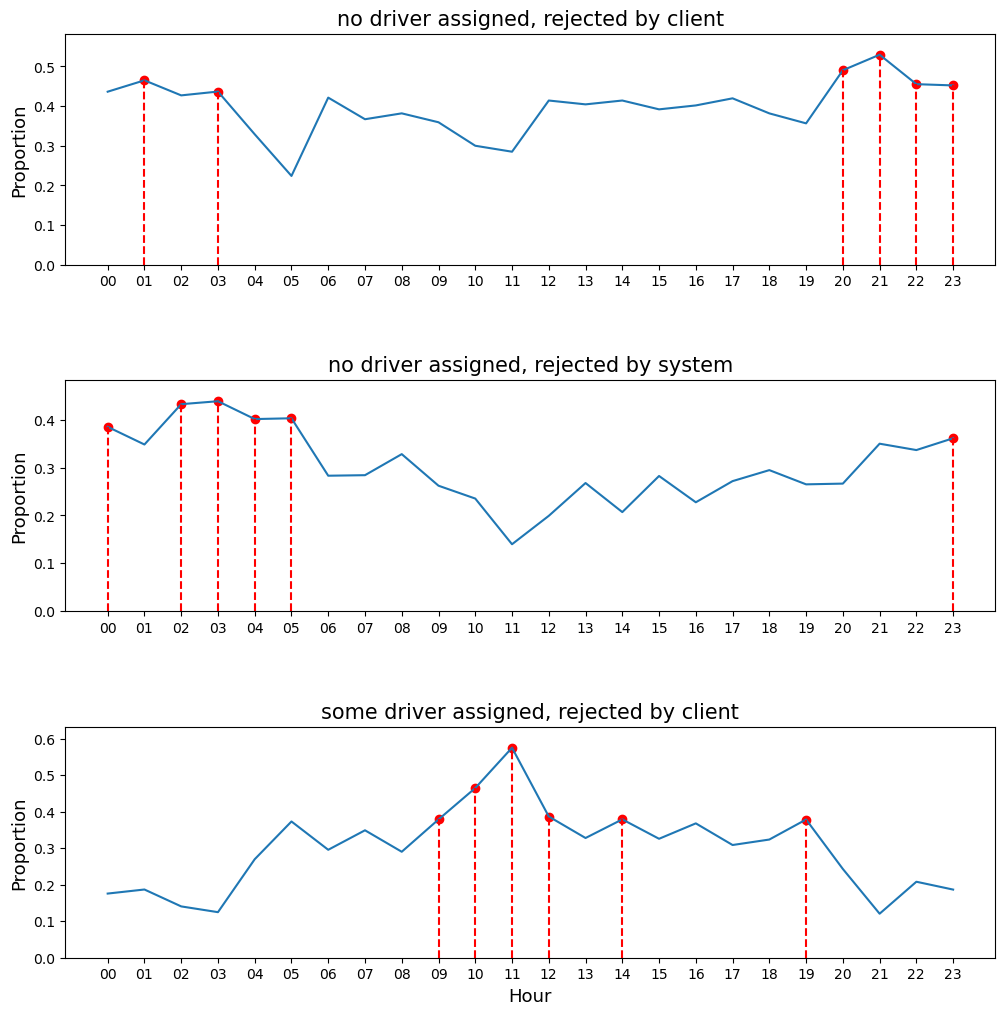

In [79]:
fig, axs = plt.subplots(3, 1, figsize = (12, 12))

data_nc = df_order_nc.groupby("hour").size() / fail_hour
data_ns = df_order_ns.groupby("hour").size() / fail_hour
data_sc = df_order_sc.groupby("hour").size() / fail_hour

axs[0].plot(data_nc)
axs[1].plot(data_ns)
axs[2].plot(data_sc)

for i, data in zip([0,1,2], [data_nc, data_ns, data_sc]):

    high_points = data.nlargest(6)

    axs[i].scatter(high_points.index, high_points.values, color='r')
    for x, y in zip(high_points.index, high_points.values):
        axs[i].vlines(x=x, ymin=0, ymax=y, color='r', linestyle='--')
    
    axs[i].set_ylim(0, max(data) * 1.1)
    axs[i].set_ylabel("Proportion", fontsize=13)
    axs[i].set_title(labels[i], fontsize=15)
    
plt.xlabel("Hour", fontsize=13)
plt.subplots_adjust(hspace = 0.5)
plt.show()

Here we can see that the three types:
1. no driver assigned, rejected by client
2. no driver assigned, rejected by system
3. some driver assigned, rejected by client

all have their own peak times in the sence of proportion, with type-1 in the evening (20:00 ~ 23:00), type-2 in the late night (0:00 ~ 5:00) and type-3 in the late morning (9:00 ~ 12:00). 

Here is a possible explanation for this phenominon. In the evening, the potential offers of taxi decreases and the impatient clients (who rush for dinner, entertainment and rest) withdraw their orders, resulting a type-1 failure; in the late night, the offers are even less but the clients (who has been already away from the bedtime routine) are more willing to wait, resulting a type-2 failure; in the morning, the offers increase, but the clients (who rush for work or later rush for lunch) are even more impatient, hence they would reject some unsatisfactory offers, resulting a type-3 failure.

## 3. Average Cancel Time by Hours

+ Obtain the records with cancel time (those rejected by the client)

In [80]:
df_order_status4 = df_order[~df_order["cancellations_time_in_seconds"].isna()]
df_order_status4["cancellations_time_in_seconds"].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

+ Boxplot to check and remove the outliers (if any).

<Axes: xlabel='cancellations_time_in_seconds'>

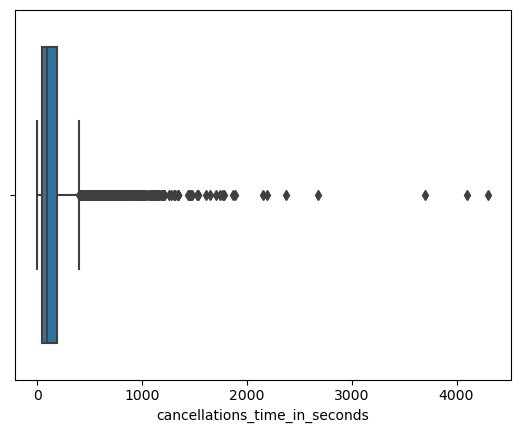

In [81]:
import seaborn as sns

sns.boxplot(x=df_order_status4["cancellations_time_in_seconds"])

+ Remove the outliers (those beyond the [Q(0.25)-1.5IQR, Q(0.75)+1.5IQR])

In [82]:
Q1 = df_order_status4["cancellations_time_in_seconds"].quantile(0.25)
Q3 = df_order_status4["cancellations_time_in_seconds"].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR

cancl_time_drop = df_order_status4[(df_order_status4["cancellations_time_in_seconds"] >= lb) & 
    (df_order_status4["cancellations_time_in_seconds"] <= ub)]["cancellations_time_in_seconds"]

In [83]:
cancl_time_drop

0        198.0
1        128.0
2         46.0
3         62.0
9         78.0
         ...  
10711     36.0
10712      4.0
10713     34.0
10714      6.0
10715     40.0
Name: cancellations_time_in_seconds, Length: 6715, dtype: float64

<Axes: xlabel='cancellations_time_in_seconds'>

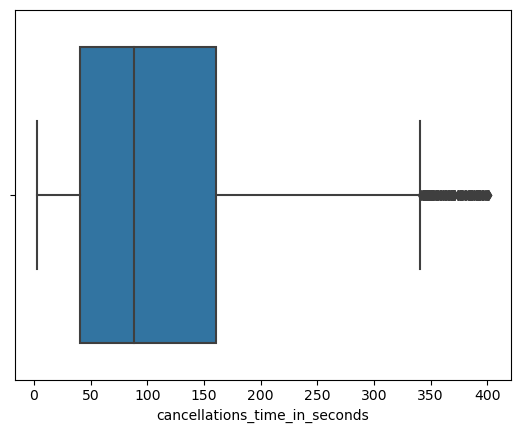

In [84]:
sns.boxplot(x=cancl_time_drop)

+ Lineplot the average cancel time by hour

In [85]:
df_order_status4_wd = df_order_status4[df_order_status4["is_driver_assigned_key"] == 1]
df_order_status4_nd = df_order_status4[df_order_status4["is_driver_assigned_key"] == 0]

In [86]:
cancl_time_drop_wd = df_order_status4_wd.groupby("hour")["cancellations_time_in_seconds"].mean()
cancl_time_drop_nd = df_order_status4_nd.groupby("hour")["cancellations_time_in_seconds"].mean()
cancl_time_drop_wd

hour
00    293.616667
01    247.715909
02    303.307692
03    292.640625
04    243.219512
05    314.400000
06    272.553191
07    188.891026
08    189.025478
09    216.493590
10    197.860759
11    258.423423
12    240.686869
13    248.541667
14    235.618557
15    206.349650
16    220.465649
17    248.125749
18    268.082090
19    198.741667
20    206.692982
21    214.460784
22    232.080537
23    284.557692
Name: cancellations_time_in_seconds, dtype: float64

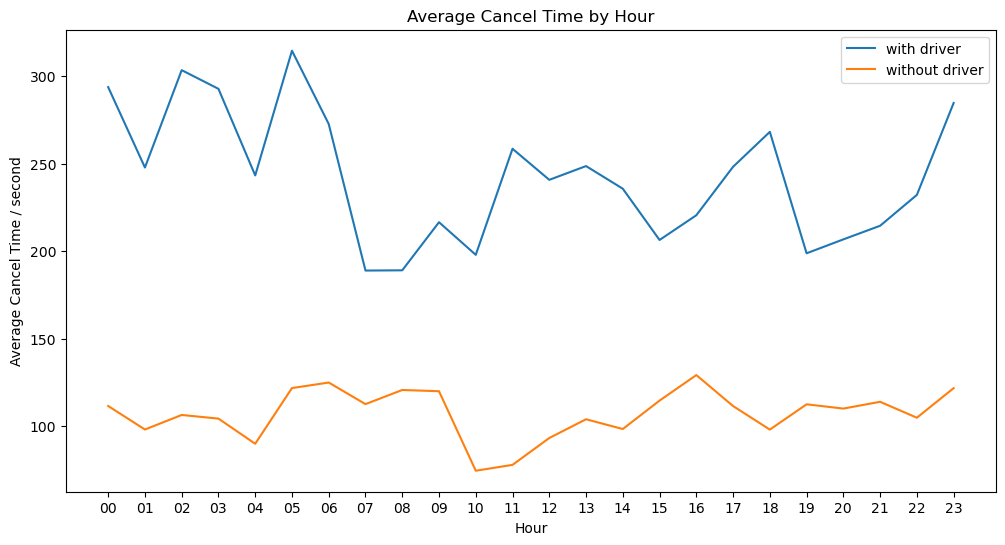

In [87]:
plt.figure(figsize=(12, 6))

plt.plot(cancl_time_drop_wd.index, cancl_time_drop_wd.values, label='with driver')

plt.plot(cancl_time_drop_nd.index, cancl_time_drop_nd.values, label='without driver')

plt.xlabel('Hour')
plt.ylabel('Average Cancel Time / second')
plt.title('Average Cancel Time by Hour')
plt.legend()

plt.show()

We can explain this plot by the following:
+ Once a driver has been assigned, the client turn to wait for the arrival, although they will still reject the order if the driver is too late. Hence the cancel time in the cases when a driver has been assigned is much longer than those when no driver has been assigned.
+ The blue line shows the patience of client for waiting a matched driver, while the orange line shows the patience for finding a taxi. The orange line is relatively stable except that in the late morning (10:00 ~ 12:00) the curve reaches its valley. This indicates that the clients are much less patient in the morning rush hour than in other time periods of a day (they feel so emergent that they will quickly turn to other commutes), which is consistent with the analysis in task 2 (type-3 failure). 
+ However, in the same period of time, the blue line does not act as the same way. This indicates that the clients become more patient once they have found a driver, and this willingness even reaches a small peak during the whole day, showing the increasing demand for taxi in this period.
+ For the blue line, the evening (19:00 ~ 23:00) is another valley, indicating that the clients are less patient in this period, consistent with the analysis in task 2 (type-1 failure); the late night (23:00 ~ 5:00) is another peak, showing that under the low supply of taxi, the clients become patient again, consistent with the analysis in task 2 (type-2 failure).

## 4. Average ETA by Hour

+ Check and remove the outlier of ETA

<Axes: >

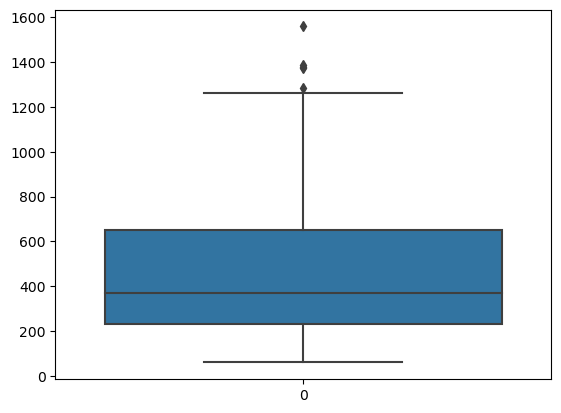

In [88]:
df_order_wd = df_order[df_order["is_driver_assigned_key"] == 1]
sns.boxplot(df_order_wd["m_order_eta"])

+ No severe outlier. Line plot the average ETA by hour.

Text(0.5, 1.0, 'Average ETA by Hour')

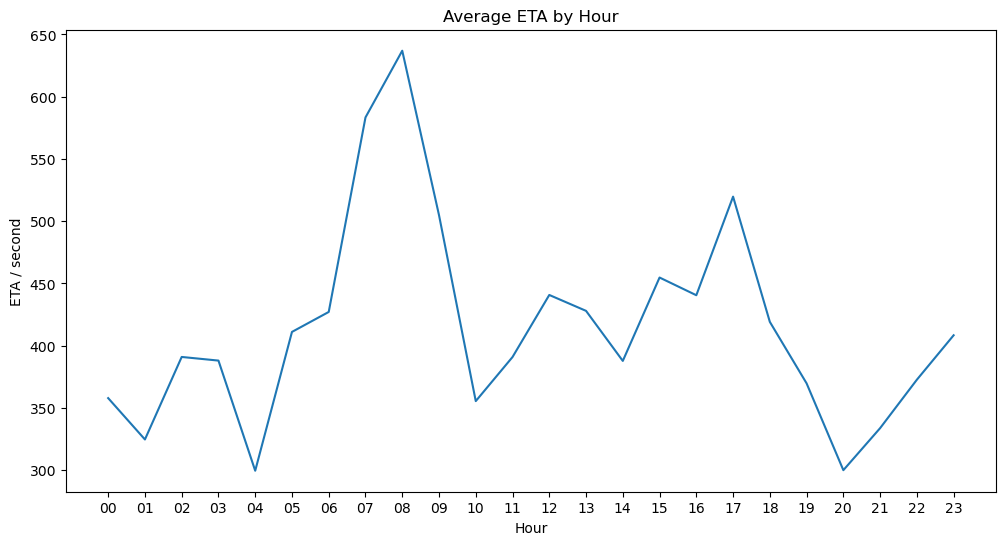

In [89]:
eta = df_order_wd.groupby("hour")["m_order_eta"].mean()

plt.figure(figsize = (12, 6))
plt.plot(eta)
plt.xlabel("Hour")
plt.ylabel("ETA / second")
plt.title("Average ETA by Hour")

This plot quantify the difficulty of finding a taxi over the day, also showing a morning-evening-peak pattern. 